In [11]:
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import my_wise_utility_v2 as my_wise_ut
import astropy.io.fits as pf
import warnings
from astropy.table import Table, vstack
from desi_retriever.blanc import get_specs
import scipy.ndimage as sn
warnings.filterwarnings('ignore')

In [2]:
def deltachi2_limit_maximize(catalog,log_deltach2_bin):
    
    fraction = []
    for i in range(0,len(log_deltach2_bin['average_bin'])):
        search = np.where(np.log10(catalog['DELTACHI2_cas'])>=log_deltach2_bin['bin'][i])
        good_catalog,bad_catalog,bad_1,bad_2 = good_robust_redrock_redshift(catalog[search[0]])
        
        fraction.append(len(good_catalog)*1.0/len(search[0]))
        
    return log_deltach2_bin['bin'][0:-1],fraction

In [3]:
def sub_sample_based_on_depth(data,depth_min, depth_max):
    return data[(data['R_DEPTH_EBVAIR']>=depth_min) & (data['R_DEPTH_EBVAIR']<depth_max)]

In [4]:
def good_robust_redrock_redshift(data):
    dz = abs(data['Z']-data['best_z'])/(1.+data['best_z'])
    search = np.where((dz<=0.0033) & (data['best_quality']>=2.5))
    search_bad = np.where((dz>0.0033) | (data['best_quality']<2.5))
    search_bad_1 = np.where((dz>0.0033) & (data['best_quality']>=2.5))
    search_bad_2 = np.where((dz<0.0033) & (data['best_quality']<2.5))
    return data[search[0]],data[search_bad[0]],data[search_bad_1[0]],data[search_bad_2[0]]

In [5]:
def flux_to_mag(catalog):
    g = -2.5*np.log10(catalog['FIBERFLUX_G'])+22.5-3.214*catalog['EBV']
    r = -2.5*np.log10(catalog['FIBERFLUX_R'])+22.5-2.165*catalog['EBV']
    z = -2.5*np.log10(catalog['FIBERFLUX_Z'])+22.5-1.211*catalog['EBV']
    gr_color = g-r
    rz_color = r-z
    coii = gr_color + 1.2*rz_color
    return {'g':g,'r':r,'z':z,'gr':gr_color,'rz':rz_color,'coii':coii}

In [135]:
def calculate_rate(SV_depth_catalog,SV_depth_catalog_cut):
    Total_number = len(SV_depth_catalog)
    good_catalog,bad_catalog,bad_1,bad_2 = good_robust_redrock_redshift(SV_depth_catalog)
    Total_good_number = len(good_catalog)

    Total_cut_number = len(SV_depth_catalog_cut)
    good_catalog,bad_catalog,bad_1,bad_2 = good_robust_redrock_redshift(SV_depth_catalog_cut)

    Redshift_success_rate = len(good_catalog)*1.0/Total_cut_number
    Good_data_completeness = len(good_catalog)*1.0/Total_good_number

    print('Redshift success rate:', Redshift_success_rate)
    print('Good data completeness:', Good_data_completeness)
    print('Combined value:',Redshift_success_rate*Good_data_completeness)

In [157]:
def plot_fraction_good(good_catalog, SV_depth_catalog,log_delta_bin):
    x_all = np.log10(SV_depth_catalog['DELTACHI2_cas'])
    x_good = np.log10(good_catalog['DELTACHI2_cas'])
    all_number = []
    good_number = []
    for i_bin in range(0,len(log_delta_bin['average_bin'])):
        search = np.where((x_all>=log_delta_bin['bin'][i_bin]) & (x_all<log_delta_bin['bin'][i_bin+1]))
        all_number.append(len(search[0]))

        search = np.where((x_good>=log_delta_bin['bin'][i_bin]) & (x_good<log_delta_bin['bin'][i_bin+1]))
        good_number.append(len(search[0]))

    print(all_number)
    print(good_number)

    plt.axhline(0.985,ls='--')
    plt.plot(log_delta_bin['average_bin'],np.array(good_number)*1.0/all_number)
    for i_bin in range(0,len(log_delta_bin['average_bin'])):
        plt.text(log_delta_bin['average_bin'][i_bin],(np.array(good_number)*1.0/all_number)[i_bin]-0.08,str(all_number[i_bin]))
        plt.text(log_delta_bin['average_bin'][i_bin],(np.array(good_number)*1.0/all_number)[i_bin]-0.04,str(good_number[i_bin]))

    plt.ylim(-0.1,1.1)
    plt.xlim(0.5,3.1)

In [6]:
def plot_ELG_cc_plot(catalog):
    mag_info = flux_to_mag(catalog)
    
    plt.subplot(2,2,1)
    plt.scatter(mag_info['rz'],mag_info['gr'],s=1)
    plt.xlim(-2,2)
    plt.ylim(-1.5,1)
    plt.xlabel('r-z')
    plt.ylabel('g-r')
    
    plt.subplot(2,2,2)
    plt.scatter(mag_info['z'],mag_info['gr'],s=1)
    plt.xlim(19,24.5)
    plt.ylim(-1.5,1)
    plt.xlabel('z')
    plt.ylabel('gr')
    
    plt.subplot(2,2,3)
    plt.scatter(mag_info['z'],mag_info['rz'],s=1)
    plt.xlabel('z')
    plt.ylabel('r-z')
    plt.xlim(19,24.5)
    plt.ylim(-1.5,2)
    
    plt.subplot(2,2,4)
    plt.scatter(mag_info['z'],mag_info['coii'],s=1)
    plt.xlabel('z')
    plt.ylabel('coii')
    plt.xlim(19,24.5)
    plt.ylim(-1.5,3)

In [183]:
#dataname = 'ELG_80606_Cascades_subsamples.fits'
dataname ='LRG_80605_80609.fits'

dir = '/Users/tlan/Dropbox/Astro_Research/Projects_plots_notes/2020_DESI_visual_inspect/SV1/Cascades_subsamples/'
SV_depth_catalog = pf.getdata(dir+dataname,1)
SV_depth_catalog_cut = SV_depth_catalog#[(SV_depth_catalog['DELTACHI2_cas']>20) & (SV_depth_catalog['Z']<1.3)]
print('No cut at all')
calculate_rate(SV_depth_catalog,SV_depth_catalog_cut)

print('--------')
SV_depth_catalog_cut = SV_depth_catalog[(SV_depth_catalog['DELTACHI2_cas']>20)]# & (SV_depth_catalog['Z']<1.3)]
print('DELTACHI2_cas>20')
calculate_rate(SV_depth_catalog,SV_depth_catalog_cut)

print('--------')
SV_depth_catalog_cut = SV_depth_catalog[(SV_depth_catalog['DELTACHI2_cas']>30)]# & (SV_depth_catalog['Z']<1.3)]
print('DELTACHI2_cas>30')
calculate_rate(SV_depth_catalog,SV_depth_catalog_cut)

print('--------')
SV_depth_catalog_cut = SV_depth_catalog[(SV_depth_catalog['DELTACHI2_cas']>20) & (SV_depth_catalog['Z']<1.4)]
print('DELTACHI2_cas>20 & Redrock_z<1.4')
calculate_rate(SV_depth_catalog,SV_depth_catalog_cut)

print('--------')
SV_depth_catalog_cut = SV_depth_catalog[(SV_depth_catalog['DELTACHI2_cas']>30) & (SV_depth_catalog['Z']<1.4)]
print('DELTACHI2_cas>30 & Redrock_z<1.4')
calculate_rate(SV_depth_catalog,SV_depth_catalog_cut)

No cut at all
Redshift success rate: 0.94383600112328
Good data completeness: 1.0
Combined value: 0.94383600112328
--------
DELTACHI2_cas>20
Redshift success rate: 0.9704462326261888
Good data completeness: 0.9867598928890211
Combined value: 0.9575974205607721
--------
DELTACHI2_cas>30
Redshift success rate: 0.9759750852736171
Good data completeness: 0.979024099970247
Combined value: 0.955503129453388
--------
DELTACHI2_cas>20 & Redrock_z<1.4
Redshift success rate: 0.9804560260586319
Good data completeness: 0.9851234751562035
Combined value: 0.9658702476287206
--------
DELTACHI2_cas>30 & Redrock_z<1.4
Redshift success rate: 0.9841222288795686
Good data completeness: 0.9773876822374293
Combined value: 0.9618689443229345


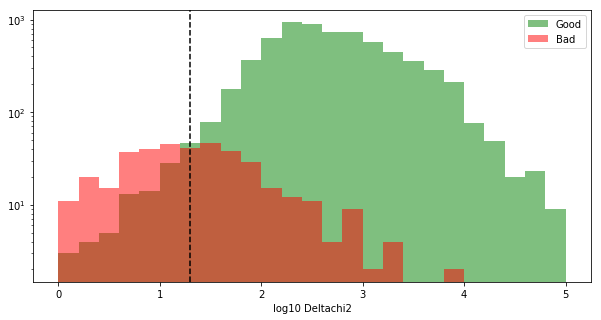

In [152]:
SV_depth_catalog = pf.getdata(dir+dataname,1)
good_catalog,bad_catalog,bad_1,bad_2=good_robust_redrock_redshift(SV_depth_catalog)
#plt.hist(np.log10(SV_depth_catalog['DELTACHI2_cas']),range=(0,5),bins=20,color='b',alpha=0.3)
plt.figure(figsize=(10,5))
plt.hist(np.log10(good_catalog['DELTACHI2_cas']),range=(0,5),bins=25,alpha=0.5,color='g',label='Good')
plt.hist(np.log10(bad_catalog['DELTACHI2_cas']),range=(0,5),bins=25,alpha=0.5,color='r',label='Bad')
plt.axvline(np.log10(20),ls='--',color='black')
plt.legend()
plt.xlabel('log10 Deltachi2')
plt.yscale('log')

(0, 5)

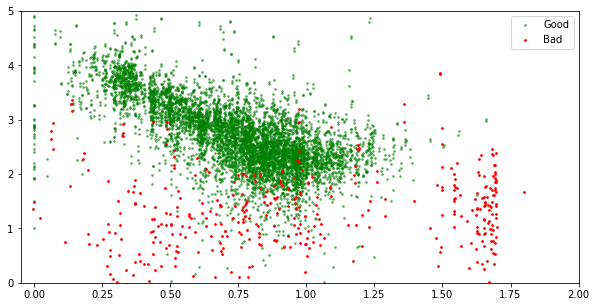

In [181]:
plt.figure(figsize=(10,5))
plt.scatter(good_catalog['Z'],np.log10(good_catalog['DELTACHI2_cas']),color='g',s=3,alpha=0.5,label='Good')
plt.scatter(bad_catalog['Z'],np.log10(bad_catalog['DELTACHI2_cas']),color='r',s=3,alpha=1,label='Bad')
plt.legend()
plt.xlim(-0.05,2)
plt.ylim(0,5)

[18, 37, 30, 40, 45, 63, 59, 81, 106, 158, 260, 330, 491, 617, 641, 584, 484, 469, 478]
[3, 10, 8, 11, 16, 30, 32, 51, 83, 133, 244, 311, 483, 610, 629, 580, 482, 464, 472]


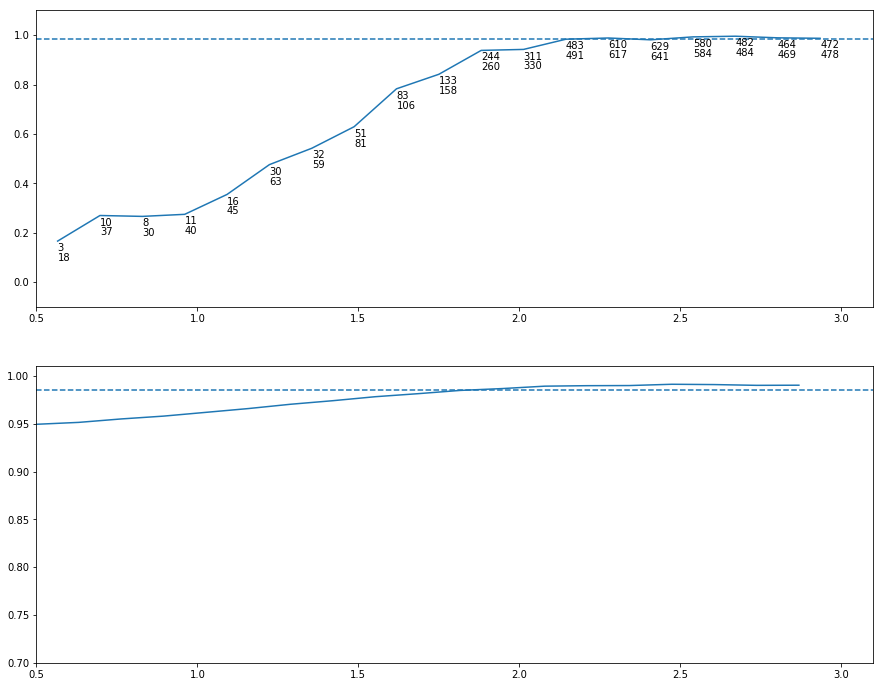

In [159]:
log_deltach2_bin = my_wise_ut.my_bin_maker(0.5,3,20)
plt.figure(figsize=(15,12))
plt.subplot(2,1,1)
plot_fraction_good(good_catalog,SV_depth_catalog,log_deltach2_bin)
bins, fraction = deltachi2_limit_maximize(SV_depth_catalog,log_deltach2_bin)
plt.subplot(2,1,2)
plt.plot(bins,fraction)
plt.ylim(0.7,1.01)
plt.xlim(0.5,3.1)
plt.axhline(0.985,ls='--')

In [435]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
dataname = 'ELG_80608_Cascades_subsamples.fits'
SV_depth_catalog = pf.getdata(dir+dataname,1)

SV_depth_catalog = SV_depth_catalog[np.where((SV_depth_catalog['subset_id']==1) & (SV_depth_catalog['DELTACHI2_cas']<100) & (SV_depth_catalog['DELTACHI2_cas']>10) & (SV_depth_catalog['Z']>=0.6) & (SV_depth_catalog['Z']<1.62))]
good_catalog,bad_catalog,bad_1,bad_2 = good_robust_redrock_redshift(SV_depth_catalog)

X = np.zeros((len(good_catalog['Z']),6))
X[:,0]=np.log10(good_catalog['DELTACHI2_cas'])
output = flux_to_mag(good_catalog)
X[:,1]=output['gr']
X[:,2]=output['rz']
X[:,3]=good_catalog['Z']
X[:,4]=output['coii']
#X[:,15]=abs(good_catalog['coeff'].T[3]**2)*abs(good_catalog['coeff'].T[5]**2)


X2 = np.zeros((len(bad_catalog['Z']),6))
X2[:,0]=np.log10(bad_catalog['DELTACHI2_cas'])
output = flux_to_mag(bad_catalog)
X2[:,1]=output['gr']
X2[:,2]=output['rz']
X2[:,3]=bad_catalog['Z']
X2[:,4]=output['coii']
X2[:,5]=bad_catalog['FIBER']
X = np.append(X,X2,axis=0)
y = np.zeros((len(X)))
y[0:len(good_catalog['Z'])]=np.int64(1)
y[len(good_catalog['Z']):]=np.int64(0)

In [439]:
clf = RandomForestClassifier(random_state=2,max_depth=4)
clf.fit(X, y)
clf.score(X,y)

0.8883071553228621

In [440]:
dataname = 'ELG_80606_Cascades_subsamples.fits'
SV_depth_catalog = pf.getdata(dir+dataname,1)
SV_depth_catalog = SV_depth_catalog[np.where((SV_depth_catalog['subset_id']==1) & (SV_depth_catalog['DELTACHI2_cas']<100) & (SV_depth_catalog['DELTACHI2_cas']>10) & (SV_depth_catalog['Z']>=0.6) & (SV_depth_catalog['Z']<1.62))]
good_catalog,bad_catalog,bad_1,bad_2 = good_robust_redrock_redshift(SV_depth_catalog)

X = np.zeros((len(good_catalog['Z']),6))
X[:,0]=np.log10(good_catalog['DELTACHI2_cas'])
output = flux_to_mag(good_catalog)
X[:,1]=output['gr']
X[:,2]=output['rz']
X[:,3]=good_catalog['Z']
X[:,4]=output['coii']
X[:,5]=good_catalog['FIBER']
#X[:,15]=abs(good_catalog['coeff'].T[3]**2)*abs(good_catalog['coeff'].T[5]**2)


X2 = np.zeros((len(bad_catalog['Z']),6))
X2[:,0]=np.log10(bad_catalog['DELTACHI2_cas'])
output = flux_to_mag(bad_catalog)
X2[:,1]=output['gr']
X2[:,2]=output['rz']
X2[:,3]=bad_catalog['Z']
X2[:,4]=output['coii']
X2[:,5]=bad_catalog['FIBER']
X = np.append(X,X2,axis=0)
y = np.zeros((len(X)))
y[0:len(good_catalog['Z'])]=np.int64(1)
y[len(good_catalog['Z']):]=np.int64(0)

In [441]:
clf.score(X,y)

0.8255250403877221

In [442]:
clf.feature_importances_

array([0.61733675, 0.0721144 , 0.08833357, 0.12957261, 0.06938848,
       0.02325417])

In [443]:
clf.score(X,y)

0.8255250403877221

In [444]:
new_predict = clf.predict(X)

In [445]:
probability = clf.predict_proba(X)

In [449]:
Trust = []
for i in range(0,len(new_predict)):
    if np.max(probability[i])>0.95:
        Trust.append(1)
    else:
        Trust.append(0)

In [450]:
np.sum(abs(new_predict[np.where(np.array(Trust)==1)[0]]-y[np.where(np.array(Trust)==1)[0]]))


2.0

In [452]:
X[np.where((np.array(Trust)==1)),0]

array([[1.9613198 , 1.96557814, 1.81126566, 1.84951679, 1.86383722,
        1.83165512, 1.95570102, 1.82927076, 1.9060957 , 1.92732217,
        1.87141895, 1.92298993, 1.94753802, 1.91172046, 1.84135229,
        1.97089687, 1.99081127, 1.97042634, 1.76754279, 1.97440712,
        1.80939702, 1.97657984, 1.82215344, 1.75425236, 1.95095918,
        1.97111138, 1.96188647, 1.94234922, 1.90581378, 1.84134145,
        1.86943482, 1.97699265, 1.89024304, 1.97507389, 1.75212439,
        1.94891704, 1.95487403, 1.87257636, 1.92517809, 1.89882317,
        1.77851552, 1.91769799, 1.800169  , 1.89123647, 1.78747663,
        1.76286075, 1.73296137, 1.87907126, 1.95039798, 1.87228073,
        1.97051959, 1.84779307, 1.82693507, 1.85110217, 1.9111457 ,
        1.93607983, 1.82106744, 1.9821759 , 1.92893556, 1.97297647,
        1.93868432, 1.9310517 , 1.73494721, 1.86826037, 1.98028769,
        1.91932963, 1.97945379, 1.9578566 , 1.90318203, 1.77615584,
        1.92992551, 1.83210985, 1.95223866, 1.86

778

475